# Machine Vision
## Assignment 4 - Texture

## Personal details

* **Name(s):** `PUT YOUR NAME(S) HERE.`
* **Student ID(s):** `PUT YOUR STUDENT ID(S) HERE.`

## Introduction

This assignment explores the use of filter banks and local binary patterns (LBP) for face recognition. There are a variety of use-cases for face recognition, including identity verification, human-computer interaction, desktop login and parental control. The goal is to create a classifier that can determine to which of the training classes a given face belongs (Figure 1).

![figure1.jpg](attachment:figure1.jpg)

The folder `images/train/` contains five different face images that will be used to train the classifier. We will first visualize these faces and compute their grayscale histograms, storing them in a $5 \times 256$ matrix $H$ for later use. later use.  


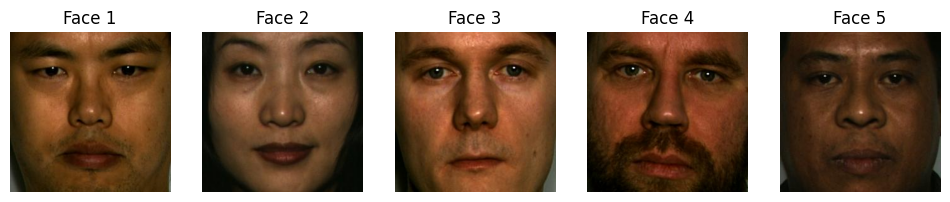

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
%matplotlib inline

# Get file paths to training images
fnames_train = sorted(glob.glob('images/train/*.jpg'))

# Number of different training faces
N = len(fnames_train)

# We will store grayscale histograms
H = np.zeros((N,256),dtype=float)

plt.figure(figsize=(12,5))

for i in range(0,N):

    img = cv2.imread(fnames_train[i])
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Display training faces (class labels: 0,1,2,3,4)
    plt.subplot(1,N,i+1)
    plt.imshow(rgb)
    plt.title('Face %d' %(i+1))
    plt.axis('off')

    # Compute grayscale histogram for later use
    H[i,:] = np.histogram(gray.ravel(),256,density=True)[0]


The folder `images/test/` contains 50 face images that will be used to test the classifier. Let's display the first five test images.

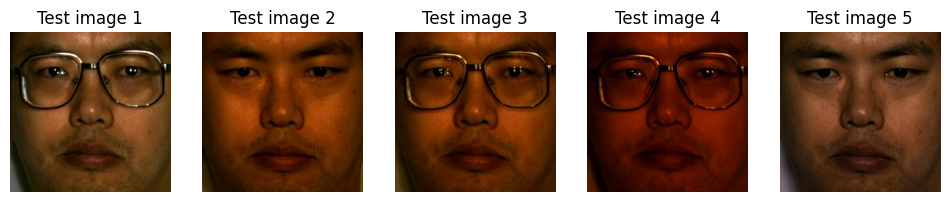

In [2]:
# Get file paths to test images
fnames_test = sorted(glob.glob('images/test/*.jpg'))

plt.figure(figsize=(12,5))

for i in range(0,5):

    img = cv2.imread(fnames_test[i])
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display five test faces
    plt.subplot(1,5,i+1)
    plt.imshow(rgb)
    plt.title('Test image %d' %(i+1))
    plt.axis('off')

All of these faces correspond to Face 1. Notice that the face color varies greatly depending on the lighting conditions. Instead of relying on the color information, we will perform the classification using grayscale and texture histograms.

## Histogram-based distance

To classify a face, we need to determine the distance to each of the training histograms stored in `H`. Let's pick one test image and compute its grayscale histogram `h`.

Text(0.5, 1.0, 'Grayscale histogram')

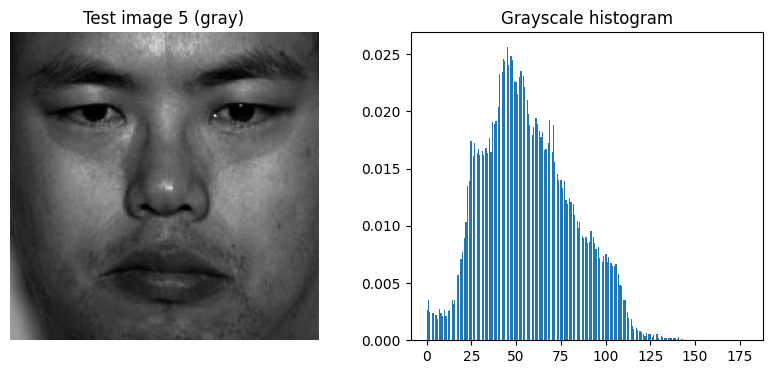

In [3]:
img = cv2.imread(fnames_test[4])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(gray,cmap='gray')
plt.title('Test image 5 (gray)')
plt.axis('off')
plt.subplot(122)
h = plt.hist(gray.ravel(),256,density=True)[0]
plt.title('Grayscale histogram')

**Computing $L_1$ distances**

To measure the similarity between two histograms, $H_i$ and $h$, we can use various distance metrics. In this assignment, we will use the $L_1$ distance, defined as:

$$
L_1(H_i,h) = \sum_{m=1}^{K} |H_i(m) - h(m)|, \qquad \qquad (1)
$$

where $K$ is the number of bins.

The function `histogramDistance` computes the $L_1$ distance between a test histogram `h` and each training histogram `H[i, :]`. The test face will be classified based on these histogram distances.

In [4]:
# INPUT
# H : Training histograms (5xK matrix)
# h : Test histogram (1xK vector)
#
# OUTPUT
# dists: L1 distances between a test histogram
#        and each training histogram (5x1 vector)
#
def histogramDistances(H,h):
    dists = np.abs(H - h)
    dists = np.sum(dists,axis=1)
    return dists

# Compute L1 distances
dists = histogramDistances(H,h)
print('L1 distances:')
print(dists)

# Predict class (face)
pred = np.argmin(dists)
dist = dists[pred]
print('\nPredicted face: %d (dist = %f)' %(pred+1,dist))

L1 distances:
[1.02348424 1.21748245 1.03130705 1.23614375 1.4938191 ]

Predicted face: 1 (dist = 1.023484)


The first training histogram is the most similar to `h`, leading us to conclude that the given face corresponds to Face 1. While the classification is correct, the distance to the third training histogram (Face 3) was also small, meaning the face was close to being misclassified.  


## Task 1 - Confusion matrix (0.50 points)

In the previous section, we classified a single face by comparing grayscale histograms. Next, we will classify all test images. We will also build a confusion matrix $C$ to report the classification results. In the confusion matrix, the entry $C(i,j)$ shows how many times a face was classified as class $j$ when the true class was $i$. Run the following code cell and answer the questions below.


In [5]:
# Confusion matrix
C = np.zeros((N,N),dtype=int)

for fname in fnames_test:

    # Extract the true class from the file name
    i = int(fname[-8]) - 1

    # Read test face
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Compute histogram
    h = np.histogram(gray.ravel(),256,density=True)[0]

    # Compute L1 distances
    dists = histogramDistances(H,h)

    # Predict class (face)
    j = np.argmin(dists)

    # Record the result to the confusion matrix
    C[i,j] = C[i,j] + 1

print('Confusion matrix:')
print(C)

res = np.trace(C) / np.sum(C)
print('Score =', res)

Confusion matrix:
[[5 1 1 2 1]
 [2 2 5 0 1]
 [0 0 8 2 0]
 [1 0 5 3 1]
 [6 0 1 1 2]]
Score = 0.4


**Which one of the faces was easiest to classify based on the confusion matrix? What two classes were most often confused?**

`Face 3. because the number of TP is 8 and the number of mistakes is 2 which is better than other classes.`

## Task 2 - Face recognition using filter banks  (1.0 points)

Face classification using grayscale histograms performed poorly. To improve accuracy, we will use filter banks. First, study the filter banks from the example notebook __[`Texture.ipynb`](https://github.com/jtheikkila/mvis/blob/master/jupyter/Texture.ipynb)__.

### Instructions
Complete the function `histogramGabor`, which should follow these steps:
1. Define four Gabor filters (code provided).
2. Apply filters to the image. Normalize the image to range [0, 1] before using `cv2.filter2D`.
3. Binarize the filtered images. Pixels greater than 0 are set to 1, and others are set to 0.
4. Construct a texture map by summing the binary images with different weights (1, 2, 4, 8).
5. Calculate a histogram with 16 bins from the texture map.

After you have completed the function, proceed to the next step for testing.

In [19]:
# INPUT
# img : Grayscale image
#
# OUTPUT
# h : Histogram (1x16 vector)
#
def histogramGabor(img):

    kern1 = cv2.getGaborKernel((11, 11),3,np.pi/4,11,1)
    kern2 = cv2.getGaborKernel((11, 11),3,-np.pi/4,11,1)
    kern3 = cv2.getGaborKernel((11, 11),2,np.pi/4,5,1)
    kern4 = cv2.getGaborKernel((11, 11),2,-np.pi/4,5,1)

    # ---------- YOUR CODE STARTS HERE -----------

    out1 = cv2.filter2D(img.astype(np.float32)/255, -1, kern1)
    out2 = cv2.filter2D(img.astype(np.float32)/255, -1, kern2)
    out3 = cv2.filter2D(img.astype(np.float32)/255, -1, kern3)
    out4 = cv2.filter2D(img.astype(np.float32)/255, -1, kern4)

    texture_map = (out1 > 0).astype(np.uint8) + 2 * (out2 > 0).astype(np.uint8) + 4 * (out3 > 0).astype(np.uint8) + 8 * (out4 > 0).astype(np.uint8)

    h, _ = np.histogram(texture_map.ravel(), bins=16, range=(0, 16))

    # ----------- YOUR CODE ENDS HERE ------------

    return h

Next, we will repeat the classification experiment. The only difference is that we use the histograms from `histogramGabor` instead of grayscale histograms. Run the following code cell. The classification score should improve from 0.4 to 0.82.


In [20]:
# Compute histograms of training faces
H_gabor = np.zeros((N,16),dtype=float)

for i in range(0,N):

    img = cv2.imread(fnames_train[i])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    H_gabor[i,:] = histogramGabor(gray)

# Confusion matrix
C = np.zeros((N,N),dtype=int)

for fname in fnames_test:

    # Extract the true class from the file name
    i = int(fname[-8]) - 1

    # Read test face
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Compute histogram
    h = histogramGabor(gray)

    # Compute L1 distances
    dists = histogramDistances(H_gabor,h)

    # Predict class (face)
    j = np.argmin(dists)

    # Record the result to the confusion matrix
    C[i,j] = C[i,j] + 1

print('Confusion matrix:')
print(C)

res = np.trace(C) / np.sum(C)
print('Score =', res)

Confusion matrix:
[[10  0  0  0  0]
 [ 3  7  0  0  0]
 [ 1  1  8  0  0]
 [ 2  0  0  8  0]
 [ 1  0  0  1  8]]
Score = 0.82


In [ ]:
# LEAVE EMPTY

## Face recognition using LBP histograms

Local Binary Patters (LBP) have been successfully applied to many computer vision problems. One reason they are so popular is that they are very fast and easy to compute. The LBP concept was originally conceived here in the University of Oulu. Computing the LBP for a pixel involves the 8 neighbours around it. Consider the neighbourhood around pixel $x$ as presented in Figure 2.

![figure2.jpg](attachment:figure2.jpg)

We threshold the values using $x$ as a threshold $(a_{th} = 1$ if $a \geq x)$, and then assign a bit to each neighbour. The final LBP for $x$ is

$$
L_x = 2^0a_{th} + 2^1b_{th} + 2^2c_{th} + 2^3d_{th} + 2^4e_{th} + 2^5f_{th} + 2^6g_{th} + 2^7h_{th},
$$

which is an 8 bit number. The LBP transform gives us a value for each pixel. To characterize a face we can compute the histogram of LBP values. This gives us a 1 x 256 feature vector that describes the face in a given image or patch. The following function computes the LBP transform of a given image. The function also returns the LBP histogram.

(-0.5, 253.5, 253.5, -0.5)

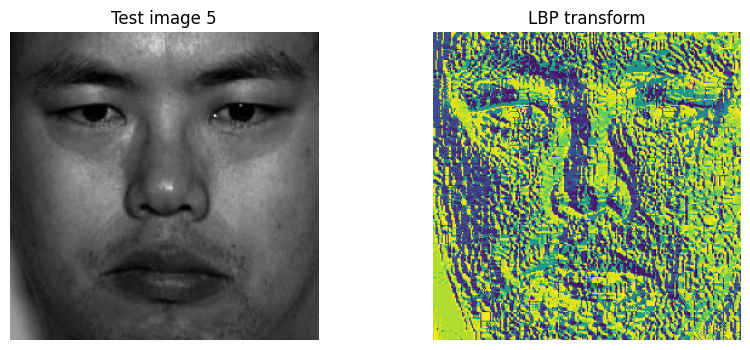

In [21]:
# INPUT
# img : Input image (grayscale)
#
# OUTPUT
# hist : LBP histogram (1x256 vector)
# out  : LBP transform of the input image
#
def histogramLBP(img):
    m,n = img.shape
    out = np.zeros((m-2, n-2, 8), dtype=np.uint8)
    disp = ((-1, -1),(-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1))
    center = img[1:-1, 1:-1]
    for i, d in enumerate(disp):
        out[:,:,i] = img[d[0] + 1 : d[0] + m - 1, d[1] + 1 : d[1] + n - 1] >= center
        out[:,:,i] = 2**i * out[:,:,i]
    out = np.sum(out, axis = 2)
    hist = np.histogram(out, 256, density=True)[0]
    return hist, out

img = cv2.imread(fnames_test[4])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
h_lbp, img_lbp = histogramLBP(gray)

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(gray,cmap='gray')
plt.title('Test image 5')
plt.axis('off')
plt.subplot(122)
plt.imshow(img_lbp)
plt.title('LBP transform')
plt.axis('off')

Let's classify the test faces using LBP histograms and report the classification results.

In [22]:
# Compute histograms of training faces
H_lbp = np.zeros((N,256),dtype=float)

for i in range(0,N):

    img = cv2.imread(fnames_train[i])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    H_lbp[i,:] = histogramLBP(gray)[0]

# Confusion matrix
C = np.zeros((N,N),dtype=int)

for fname in fnames_test:

    # Extract the true class from the file name
    i = int(fname[-8]) - 1

    # Read test face
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Compute histogram
    h = histogramLBP(gray)[0]

    # Compute L1 distances
    dists = histogramDistances(H_lbp,h)

    # Predict class (face)
    j = np.argmin(dists)

    # Record the result to the confusion matrix
    C[i,j] = C[i,j] + 1

print('Confusion matrix:')
print(C)

res = np.trace(C) / np.sum(C)
print('Score =', res)

Confusion matrix:
[[6 0 0 1 3]
 [1 5 2 0 2]
 [1 1 4 2 2]
 [1 0 0 7 2]
 [1 0 0 2 7]]
Score = 0.58


Although the LBP-based approach worked better compared to grayscale histograms, the classification results are still far from perfect.

## Task 3 - Patch-based LBP (0.50 points)

Previously, we computed a single LBP histogram for the whole image. An alternative approach is to divide the image into smaller patches (32 x 32 pixels), compute an LBP histogram of each patch, and concatenate them into a single histogram. Since the image size is 256 x 256 pixels, this gives us exactly 64 patches as shown in Figure 3.

![figure3.jpg](attachment:figure3.jpg)

### Instructions

Complete the function `histogramPatchLBP`. You should compute the LBP histogram of each patch and concatenate them into a single histogram. The length of the histogram should be 16384 (64 x 256). Note that you can reuse the code from the function `histogramLBP`.

After you have completed the function, proceed to the next step for testing.

In [89]:
# INPUT
# img   : Input image (grayscale)
# psize : Patch size (32 pixels)
#
# OUTPUT
# hist : LBP histogram formed by concatenating
#        the histograms of individual patches (1x16384 vector)
#
def histogramPatchLBP(img, psize=32):

    # ---------- YOUR CODE STARTS HERE -----------
    hist = []
    for i in range(0, img.shape[0], psize):
        for j in range(0, img.shape[1], psize):
            patch = img[i:i+psize, j:j+psize]
            histPatch, out = histogramLBP(patch)
            hist.append(histPatch)
    hist = np.concatenate(hist)

    # ----------- YOUR CODE ENDS HERE ------------

    return hist

Again, we repeat the classification experiment. The process of detecting faces is the same as before: (1) Compute patch-based LBP histograms of the training images `H_patch`. (2) Compute histogram distances between the training histograms `H_patch`and the test histogram `h_patch`. Your implementation should be correct if you got a perfect score of 1.0 (or close).

In [90]:
# Compute patch-based LBP histograms of training faces
H_patch = np.zeros((N,64*256),dtype=float)

for i in range(0,N):

    img = cv2.imread(fnames_train[i])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    H_patch[i,:] = histogramPatchLBP(gray)

# Confusion matrix
C = np.zeros((N,N),dtype=int)

for fname in fnames_test:

    # Extract the true class from the file name
    i = int(fname[-8]) - 1

    # Read test face
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Compute histogram
    h = histogramPatchLBP(gray)

    # Compute L1 distances
    dists = histogramDistances(H_patch,h)

    # Predict class (face)
    j = np.argmin(dists)

    # Record the result to the confusion matrix
    C[i,j] = C[i,j] + 1

print('Confusion matrix:')
print(C)

res = np.trace(C) / np.sum(C)
print('Score =', res)

Confusion matrix:
[[10  0  0  0  0]
 [ 0 10  0  0  0]
 [ 0  0 10  0  0]
 [ 0  0  0 10  0]
 [ 0  0  0  0 10]]
Score = 1.0


In [ ]:
# LEAVE EMPTY

# Aftermath

Please provide short answers to the following questions:

**1. How much time did you need to complete this exercise?**

`REPLACE THIS TEXT WITH YOUR ANSWER.`

**2. Did you experience any issues or find anything particularly confusing?**

`REPLACE THIS TEXT WITH YOUR ANSWER.`


# References

`List any references here (optional).`

# Submission

1. Go to `Kernel -> Restart & Clear Output` to remove all outputs.
2. Compress this notebook (`MV_A4.ipynb`) into `MV_A4.zip`.
3. Submit the **zip** file on Moodle.

**Deadline: 09.02.2025**